In [1]:
import os
import sys
import importlib
os.chdir("../..")
directory_path = os.path.abspath(os.path.join("src"))
if directory_path not in sys.path:
    sys.path.append(directory_path)

import EyeTraumaAnalysis

In [2]:
importlib.reload(EyeTraumaAnalysis);

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import cv2

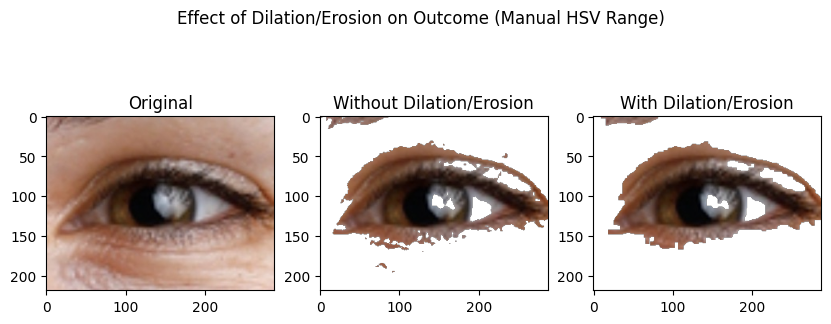

In [24]:
def show_image_seg_approaches(image, plot_region_boundaries=False):
    img_hsv = cv2.cvtColor(image.img[...,:3], cv2.COLOR_RGB2HSV)
    ht, wd, ch = img_hsv.shape;
    # center = (int(wd/2),int(ht/2));
    # bottom_region_cutoff = int(ht*95/100)
    kernel = np.ones((int(wd/50),int(ht/50)),np.uint8)

    frame_threshold = cv2.inRange(img_hsv, (0, 0, 00), (255, 255,160))
    target1 = cv2.bitwise_and(image.img,image.img, mask=frame_threshold)

    frame_threshold_morphology = cv2.morphologyEx(frame_threshold, cv2.MORPH_CLOSE, kernel) # Erosion then Dilation
    frame_threshold_morphology = cv2.morphologyEx(frame_threshold_morphology, cv2.MORPH_OPEN, kernel) # Dilation then Erosion
    target2 = cv2.bitwise_and(image.img,image.img, mask=frame_threshold_morphology)

    fig, axs = plt.subplots(1, 3, figsize=(10,4))
    axs[0].imshow(image.img);
    axs[0].set_title("Original");
    axs[1].imshow(target1);
    axs[1].set_title("Without Dilation/Erosion");
    axs[2].imshow(target2);
    axs[2].set_title("With Dilation/Erosion");
    fig.suptitle("Effect of Dilation/Erosion on Outcome (Manual HSV Range)");


image = EyeTraumaAnalysis.Image("data/01_raw/11006.jpg")
show_image_seg_approaches(image, plot_region_boundaries=False)

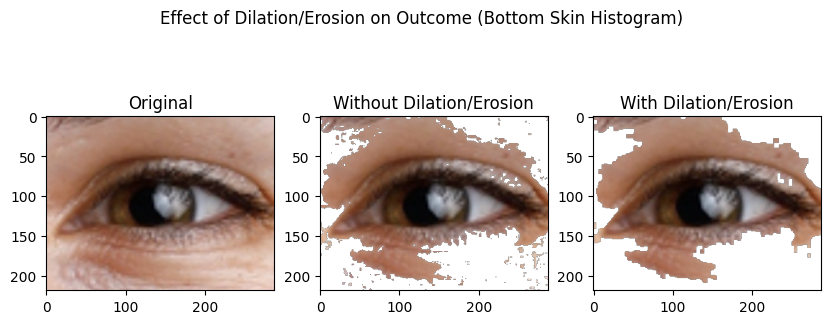

In [28]:
def show_image_seg_approaches(image, plot_region_boundaries=False):
    img_hsv = cv2.cvtColor(image.img[...,:3], cv2.COLOR_RGB2HSV)
    ht, wd, ch = img_hsv.shape;
    center = (int(wd/2),int(ht/2));
    bottom_region_cutoff = int(ht*95/100)
    kernel = np.ones((int(wd/50),int(ht/50)),np.uint8)

    # get bottom region as ground truth for skin
    region_hsv1 = img_hsv[bottom_region_cutoff:,:,:3]  # :3 removes alpha channel
    percentiles1 = np.quantile(region_hsv1,[0.01, 0.99], axis=[0,1])

    # pupil histogram data
    center_region_mask = np.zeros(img_hsv.shape[:2]);
    center_region_mask = cv2.circle(center_region_mask, center, int(ht/10), 255, -1)
    center_region_hsv = img_hsv.reshape( (-1,ch) )[center_region_mask.flatten().astype(bool),:] # flatten circle array
    percentiles2 = np.quantile(center_region_hsv,[0.01, 0.99], axis=[0])

    
    frame_threshold = cv2.inRange(img_hsv, percentiles1[0], percentiles1[1])
    # frame_threshold = cv2.inRange(img_hsv, (0, 0, 00), (255, 255,160))
    target1 = cv2.bitwise_and(image.img,image.img, mask=~frame_threshold)

    frame_threshold_morphology = cv2.morphologyEx(frame_threshold, cv2.MORPH_CLOSE, kernel) # Erosion then Dilation
    frame_threshold_morphology = cv2.morphologyEx(frame_threshold_morphology, cv2.MORPH_OPEN, kernel) # Dilation then Erosion
    target2 = cv2.bitwise_and(image.img,image.img, mask=~frame_threshold_morphology)

    fig, axs = plt.subplots(1, 3, figsize=(10,4))
    axs[0].imshow(image.img);
    axs[0].set_title("Original");
    axs[1].imshow(target1);
    axs[1].set_title("Without Dilation/Erosion");
    axs[2].imshow(target2);
    axs[2].set_title("With Dilation/Erosion");
    fig.suptitle("Effect of Dilation/Erosion on Outcome (Bottom Skin Histogram)");


image = EyeTraumaAnalysis.Image("data/01_raw/11006.jpg")
show_image_seg_approaches(image, plot_region_boundaries=False)